#Introduction

In this project, I am trying to create model to predict vehicle incurance claim fraud from data provided on kaggle
https://www.kaggle.com/shivamb/vehicle-claim-fraud-detection

#Imports

In [ ]:
!pip install optuna
!pip install catboost
!pip install shap
!pip install catboost --no-cache-dir

In [96]:
#Basic
import pathlib
import pandas as pd
import numpy as np

#Plots
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots

#Feature selection
from sklearn.feature_selection import RFECV

#Metrics
from sklearn.metrics import roc_auc_score, f1_score, recall_score, precision_score, average_precision_score, accuracy_score, confusion_matrix

#Model building
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
import optuna

#Models
import xgboost as xgb
import lightgbm as lgb
import catboost as ctb

import shap

%matplotlib inline

#Loading data

In [3]:
path = pathlib.Path('/content/drive/MyDrive/Colab Notebooks/Moje Projekty/fraud_oracle.csv')
df = pd.read_csv(path)

#EDA

##Basic statistic

In [4]:
df.head(5)

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,...,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy
0,Dec,5,Wednesday,Honda,Urban,Tuesday,Jan,1,Female,Single,...,3 years,26 to 30,No,No,External,none,1 year,3 to 4,1994,Liability
1,Jan,3,Wednesday,Honda,Urban,Monday,Jan,4,Male,Single,...,6 years,31 to 35,Yes,No,External,none,no change,1 vehicle,1994,Collision
2,Oct,5,Friday,Honda,Urban,Thursday,Nov,2,Male,Married,...,7 years,41 to 50,No,No,External,none,no change,1 vehicle,1994,Collision
3,Jun,2,Saturday,Toyota,Rural,Friday,Jul,1,Male,Married,...,more than 7,51 to 65,Yes,No,External,more than 5,no change,1 vehicle,1994,Liability
4,Jan,5,Monday,Honda,Urban,Tuesday,Feb,2,Female,Single,...,5 years,31 to 35,No,No,External,none,no change,1 vehicle,1994,Collision


In [5]:
df.head(5).T

,0,1,2,3,4
Month,Dec,Jan,Oct,Jun,Jan
WeekOfMonth,5,3,5,2,5
DayOfWeek,Wednesday,Wednesday,Friday,Saturday,Monday
Make,Honda,Honda,Honda,Toyota,Honda
AccidentArea,Urban,Urban,Urban,Rural,Urban
DayOfWeekClaimed,Tuesday,Monday,Thursday,Friday,Tuesday
MonthClaimed,Jan,Jan,Nov,Jul,Feb
WeekOfMonthClaimed,1,4,2,1,2
Sex,Female,Male,Male,Male,Female
MaritalStatus,Single,Single,Married,Married,Single


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15420 entries, 0 to 15419
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Month                 15420 non-null  object
 1   WeekOfMonth           15420 non-null  int64 
 2   DayOfWeek             15420 non-null  object
 3   Make                  15420 non-null  object
 4   AccidentArea          15420 non-null  object
 5   DayOfWeekClaimed      15420 non-null  object
 6   MonthClaimed          15420 non-null  object
 7   WeekOfMonthClaimed    15420 non-null  int64 
 8   Sex                   15420 non-null  object
 9   MaritalStatus         15420 non-null  object
 10  Age                   15420 non-null  int64 
 11  Fault                 15420 non-null  object
 12  PolicyType            15420 non-null  object
 13  VehicleCategory       15420 non-null  object
 14  VehiclePrice          15420 non-null  object
 15  FraudFound_P          15420 non-null

The DataFrame contains 15420 rows and 33 columns. There are no missing values. This indicates that most of the variables are of the "object" type, which typically contains text data or categories. Additionally, there are a few variables of the "int64" type.

In [7]:
df.describe()

,WeekOfMonth,WeekOfMonthClaimed,Age,FraudFound_P,PolicyNumber,RepNumber,Deductible,DriverRating,Year
count,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000
mean,2.788586,2.693969,39.855707,0.059857,7710.500000,8.483268,407.704280,2.487808,1994.866472
std,1.287585,1.259115,13.492377,0.237230,4451.514911,4.599948,43.950998,1.119453,0.803313
min,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,300.000000,1.000000,1994.000000
25%,2.000000,2.000000,31.000000,0.000000,3855.750000,5.000000,400.000000,1.000000,1994.000000
50%,3.000000,3.000000,38.000000,0.000000,7710.500000,8.000000,400.000000,2.000000,1995.000000
75%,4.000000,4.000000,48.000000,0.000000,11565.250000,12.000000,400.000000,3.000000,1996.000000
max,5.000000,5.000000,80.000000,1.000000,15420.000000,16.000000,700.000000,4.000000,1996.000000


The provided summary statistics do not show any significant outliers except for the minimum age value of 0, which could potentially be a data entry error or require additional context to understand. Overall, the dataset seems to be within reasonable ranges for the variables, and further exploration can help identify any specific patterns or anomalies.

In [8]:
sns.set_style('darkgrid')

<Axes: xlabel='FraudFound_P', ylabel='count'>

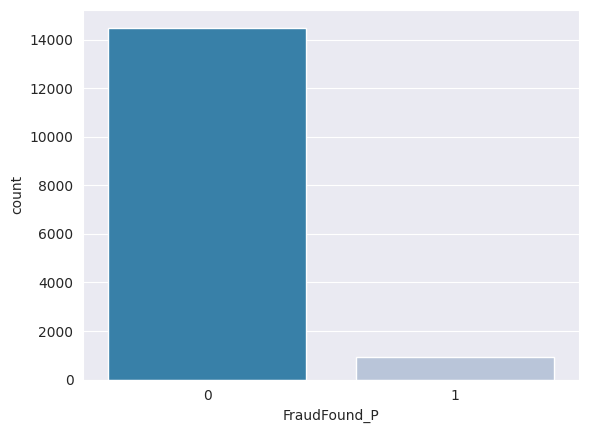

In [9]:
sns.countplot(x='FraudFound_P', data=df, palette = 'PuBu_r')

The results indicate a significant imbalance in the dataset, with a large difference in the number of cases marked as 0 (non-fraud) compared to cases marked as 1 (fraud). This strong class imbalance can affect the effectiveness of analysis and modelling, so it is important to choose the right models.

In [10]:
df.FraudFound_P.value_counts()

0    14497
1      923
Name: FraudFound_P, dtype: int64

##Graphs

'Sex'

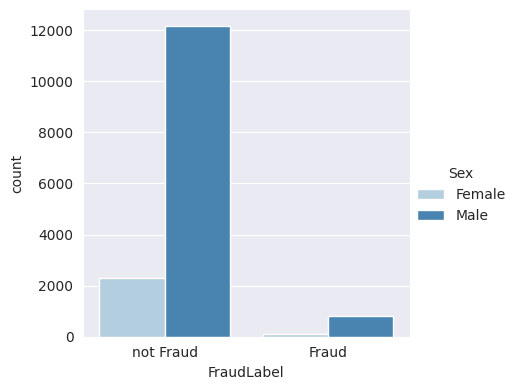

In [11]:
df['FraudLabel'] = df['FraudFound_P'].map({0: 'not Fraud', 1: 'Fraud'})

sns.catplot(data=df, x='FraudLabel', hue='Sex', kind='count',
            palette='Blues', height=4, aspect=1.1)

'Month'

In [12]:
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

fig = make_subplots(rows=1, cols=2, subplot_titles=('Fraud', 'Not Fraud'))

fig1 = px.histogram(df[df['FraudFound_P']==1], x='Month', histnorm='probability')
fig2 = px.histogram(df[df['FraudFound_P']==0], x='Month', histnorm='probability')

fig.add_trace(fig1.data[0], row=1, col=1)
fig.add_trace(fig2.data[0], row=1, col=2)

fig.update_xaxes(matches='x', categoryorder='array', categoryarray=month_order)

fig.update_layout(title_text='"Comparison of Fraud vs. Not Fraud"',
                  width=1000, height=500,
                  title_x=0.5)

fig.update_yaxes(range=[0, 0.12], row=1, col=1)
fig.update_yaxes(range=[0, 0.12], row=1, col=2)

fig.update_xaxes(title_text="Month", row=1, col=1)
fig.update_yaxes(title_text="Probability", row=1, col=1)

fig.update_xaxes(title_text="Month", row=1, col=2)
fig.update_yaxes(title_text="Probability", row=1, col=2)

The distribution of claims varies depending on whether they involve frauds or not

Text(0.5, 1.0, 'The Probability of Fraud for indyvidual months')

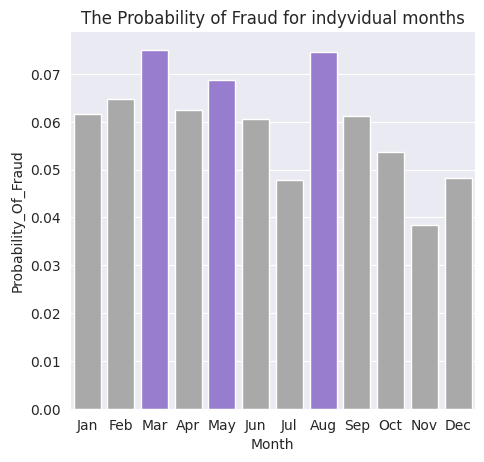

In [13]:
df_month = pd.DataFrame(df.groupby('Month').FraudFound_P.mean().reset_index())
df_month.columns = ['Month', 'Probability_Of_Fraud']

month_palette = ['darkgray', 'darkgray', 'mediumpurple', 'darkgray', 'mediumpurple', 'darkgray', 'darkgray', 'mediumpurple', 'darkgray', 'darkgray', 'darkgray', 'darkgray']

sns.catplot(data=df_month, x='Month', y='Probability_Of_Fraud', kind='bar',
            palette=month_palette, order=month_order,
            height=4.5, aspect=1.1)
plt.title('The Probability of Fraud for indyvidual months')

Amongst fraudulent cases months of March, Aug and May has relatively higher probablity.

'MonthClaimed'

In [14]:
df['MonthClaimed'].unique()

array(['Jan', 'Nov', 'Jul', 'Feb', 'Mar', 'Dec', 'Apr', 'Aug', 'May',
       'Jun', 'Sep', 'Oct', '0'], dtype=object)

In [15]:
df[df['MonthClaimed']=='0']

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,...,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy,FraudLabel
1516,Jul,2,Monday,Honda,Rural,0,0,1,Male,Single,...,16 to 17,No,No,External,none,no change,1 vehicle,1994,All Perils,not Fraud


In [16]:
df.drop(1516, axis=0, inplace=True)

The groups of the highest risk are 21 to 25, 18 to 20 and 16 to 17.

'Age'

[Text(0.5, 1.0, 'Not Fraud'), (0.0, 0.06)]

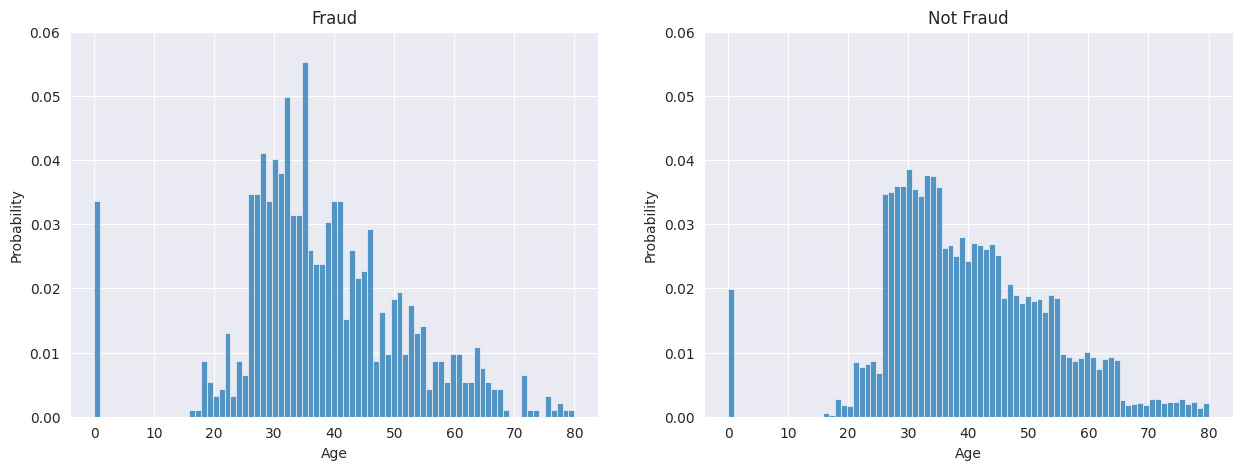

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
sns.histplot(df['Age'][df['FraudFound_P']==1], bins=81, stat='probability', ax=ax1).set(title='Fraud', ylim=(0, 0.06))
sns.histplot(df['Age'][df['FraudFound_P']==0], bins=81, stat='probability', ax=ax2).set(title='Not Fraud', ylim=(0, 0.06))

For Fraud, there is a clear difference in the age distribution compared to the Not Fraud.

Text(0.5, 0.98, 'The distribution of fraud cases by age for Female and Male')

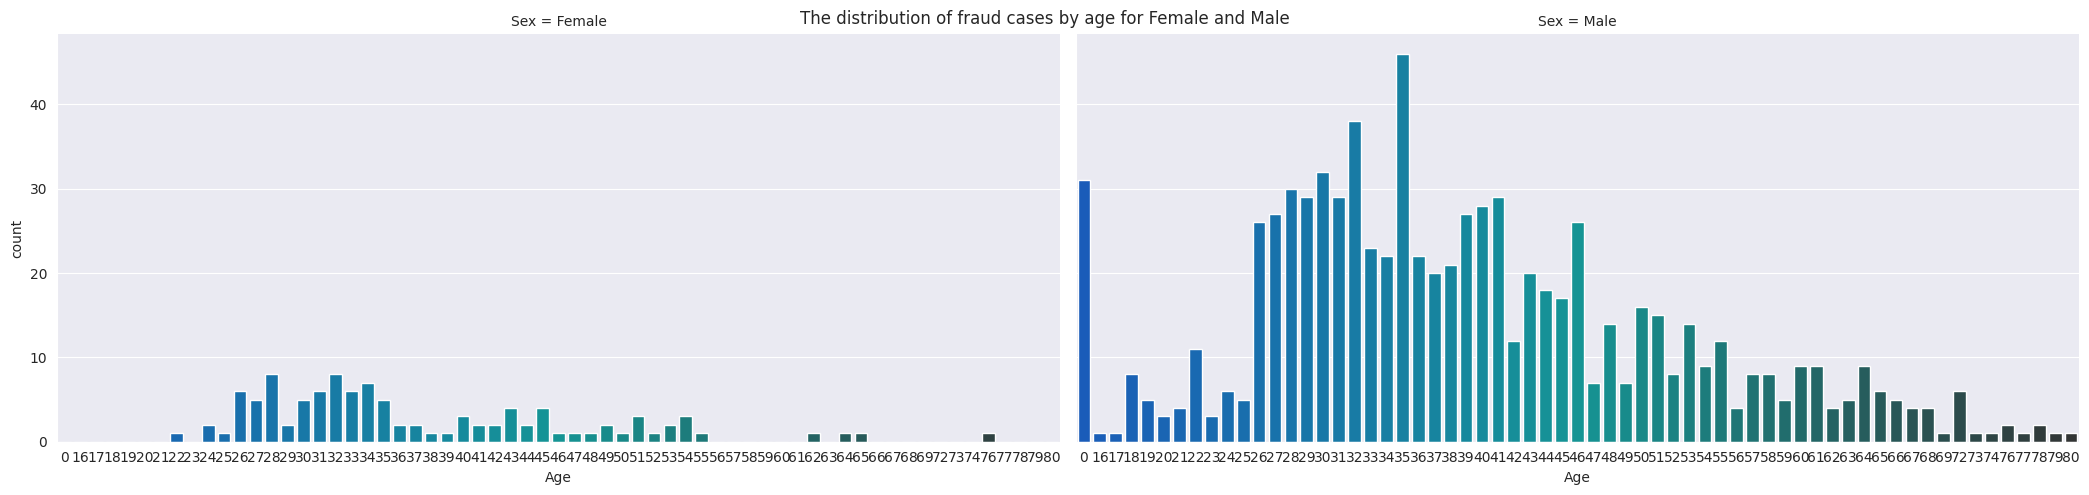

In [18]:
sns.catplot(data=df[df['FraudFound_P']==1], x='Age',  col='Sex',
            col_order=['Female', 'Male'],
            kind='count', height=5, aspect=2.1, palette='winter_d')
plt.suptitle('The distribution of fraud cases by age for Female and Male')

Text(0, 0.5, 'Probability of fraud')

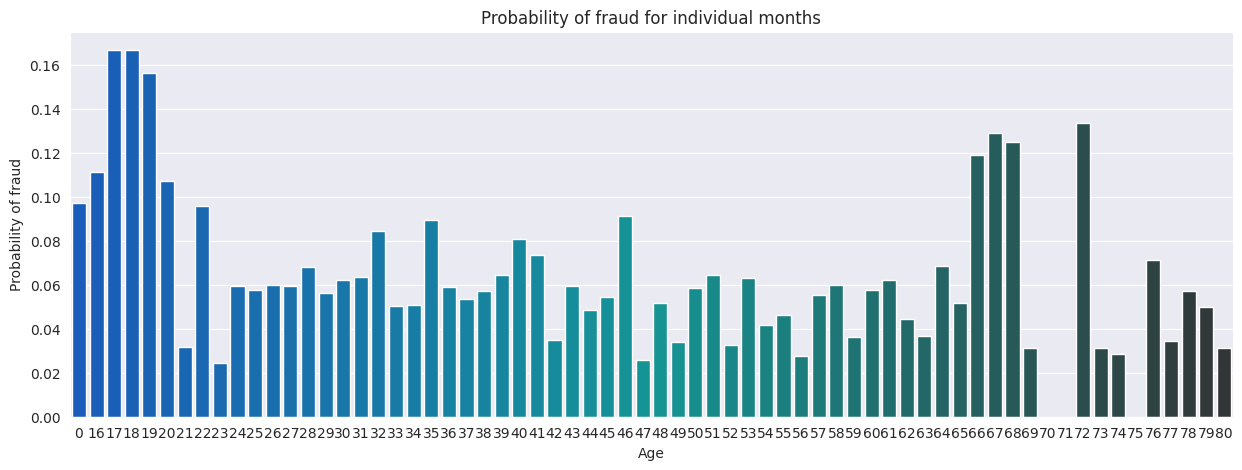

In [19]:
df_age = df.groupby('Age').FraudFound_P.mean().reset_index()

plt.figure(figsize=(15,5))
sns.barplot(data=df_age, x='Age', y='FraudFound_P', palette='winter_d')
plt.title('Probability of fraud for individual months')
plt.ylabel('Probability of fraud')

 There are ages at which the risk of fraud is higher than at other ages. The highest probability of fraud is for the age of 17, 18 and 19. While the probability is equal zero for the age of 70, 71 and 75.

'AgeOfPolicyHolder'

In [20]:
df['AgeOfPolicyHolder'].unique()

array(['26 to 30', '31 to 35', '41 to 50', '51 to 65', '21 to 25',
       '36 to 40', '16 to 17', 'over 65', '18 to 20'], dtype=object)

Text(0.5, 1.0, 'Number of claims by "AgeOfPolicyHolder"')

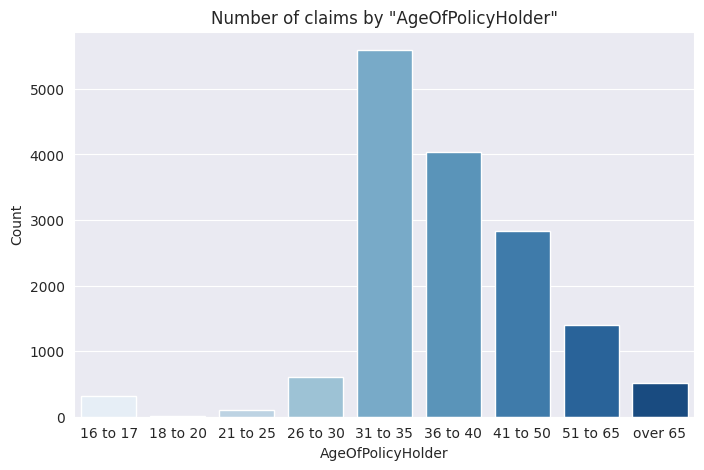

In [21]:
holder_age_order = ['16 to 17','18 to 20', '21 to 25', '26 to 30', '31 to 35', '36 to 40', '41 to 50', '51 to 65', 'over 65']

df_age_holder_counts = df['AgeOfPolicyHolder'].value_counts().reset_index()
df_age_holder_counts.columns = ['AgeOfPolicyHolder', 'Count']

plt.figure(figsize=(8,5))
sns.barplot(data=df_age_holder_counts, x='AgeOfPolicyHolder', y='Count',
            order=holder_age_order, palette='Blues')

plt.title('Number of claims by "AgeOfPolicyHolder"')

Most cases of claim occur in the age group of 31 to 35 years.

'Make'

In [22]:
px.pie(df, names='Make',
       width=600, height=450,
       color_discrete_sequence=px.colors.sequential.Blues_r,
       title='Claims by "Make"')

Pontiac, Toyota, Honda, Mazda and Chevrolet are the top 5 makes involved in claims.

'PolicyType'

In [23]:
px.pie(df, names='PolicyType',
       width=600, height=450,
       color_discrete_sequence=px.colors.sequential.Blues_r,
       title='Claims by "PolicyType"')

There are three PolcyTypes with the highest number of claims: Sedan - Collission, Sedan - Liability and Sedan - All Perils

In [24]:
fig = make_subplots(rows=1, cols=2, subplot_titles=('Fraud', 'Not Fraud'),
                    specs=[[{"type": "sunburst"}, {"type": "sunburst"}]])

fig1 = px.sunburst(df[df['FraudFound_P']==0], path=['BasePolicy','VehicleCategory'], color_discrete_sequence=px.colors.sequential.Blues_r)
fig.add_trace(fig1.data[0], row=1, col=1)

fig2 = px.sunburst(df[df['FraudFound_P']==1], path=['BasePolicy','VehicleCategory'], color_discrete_sequence=px.colors.sequential.Blues_r)
fig.add_trace(fig2.data[0], row=1, col=2)

fig.update_layout(title_text='Comparison of Fraud vs. Not Fraud for features: "BasePolicy" and "VehicleCategory"',
                  width=800, height=500, title_x=0.5,
                  sunburstcolorway = px.colors.qualitative.Prism)

fig.show()

Especially interesting is the very low number of fraud for 'Liability'.

'DayOfWeek'

Text(0.5, 1.0, 'Number of claims by "DayOfWeek"')

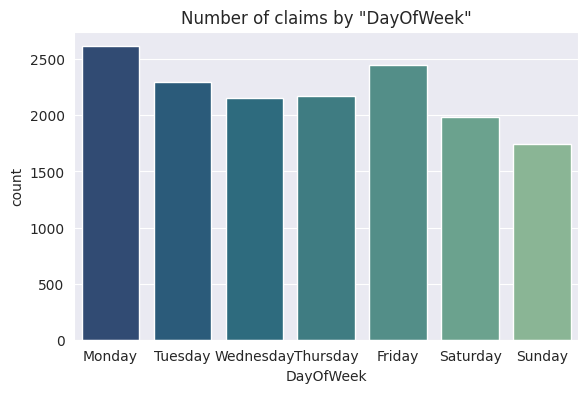

In [25]:
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.figure(figsize=(6.5,4))
sns.countplot(data=df, x='DayOfWeek', order=day_order, palette='crest_r')

plt.title('Number of claims by "DayOfWeek"')

The highest probability of claim fraud is for Sunday

'VehiclePrice'

Text(0.5, 1.0, 'Number of claims by "VehiclePrice"')

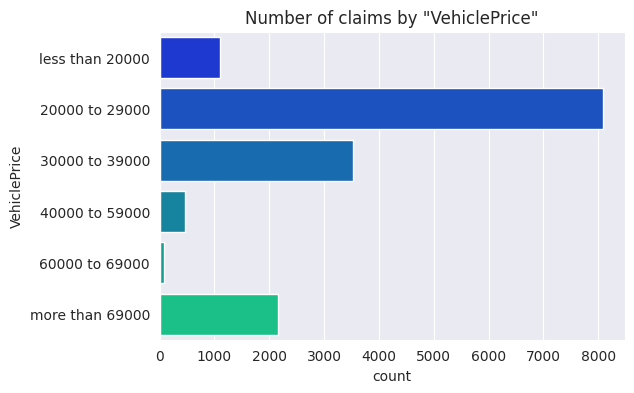

In [26]:
vehicle_price_order = ['less than 20000', '20000 to 29000', '30000 to 39000', '40000 to 59000', '60000 to 69000', 'more than 69000']

plt.figure(figsize=(6, 4))
sns.countplot(data=df, y='VehiclePrice',
              order=vehicle_price_order, palette='winter')

plt.title('Number of claims by "VehiclePrice"')

The ranges of vehicle prices with the highest probability of fraud claims are 'less than 20000' and 'more than 69000'

'Fault'

In [27]:
px.sunburst(df, path=['Fault', 'FraudLabel'],
            width=600, height=450,
            color_discrete_sequence=px.colors.qualitative.Prism,
            title='Claims by "Fault"')

The graph shows that fraud cases are very rare for 'Third Party"

##Preprocessing data

The transformation of features into binary.

In [28]:
df['PoliceReportFiled'] = df['PoliceReportFiled'].map(lambda x: 1 if x=='Yes' else 0 )
df['WitnessPresent'] = df['WitnessPresent'].map(lambda x: 1 if x=='Yes' else 0 )
df['Male'] = df['Sex'].map(lambda x: 1 if x=='Male' else 0)
df['ThirdParty'] = df['Fault'].map(lambda x: 1 if x=='Third Party' else 0)
df['Urban'] = df['AccidentArea'].map(lambda x: 1 if x=='Urban' else 0)
df['AgentType_External'] = df['AgentType'].map(lambda x: 1 if x=='External' else 0)

Deletion of the features

In [29]:
df.drop(['PolicyNumber', 'RepNumber', 'Year', 'FraudLabel', 'Sex', 'Fault', 'AccidentArea', 'AgentType'], axis=1, inplace=True)

#Feature transformation

Categorical ordinal features

In [30]:
accident_days_order = ['none', '1 to 7', '8 to 15', '15 to 30', 'more than 30']
claim_days_order = ['none', '8 to 15', '15 to 30', 'more than 30']
past_claims_order = ['none', '1', '2 to 4', 'more than 4']
vehicle_age_order = ['new', '2 years', '3 years', '4 years', '5 years', '6 years', '7 years', 'more than 7']
num_suppliments_order = ['none', '1 to 2', '3 to 5', 'more than 5']
address_changes_order = ['no change', 'under 6 months', '1 year', '2 to 3 years', '4 to 8 years']
num_cars_order = ['1 vehicle', '2 vehicles', '3 to 4', '5 to 8', 'more than 8']

ordinal_features_dict = {'Month': month_order,
                         'DayOfWeek': day_order,
                         'DayOfWeekClaimed': day_order,
                         'MonthClaimed': month_order,
                         'VehiclePrice': vehicle_price_order,
                         'Days_Policy_Accident': accident_days_order,
                         'Days_Policy_Claim': claim_days_order,
                         'PastNumberOfClaims': past_claims_order,
                         'AgeOfVehicle': vehicle_age_order,
                         'AgeOfPolicyHolder': holder_age_order,
                         'NumberOfSuppliments': num_suppliments_order,
                         'AddressChange_Claim': address_changes_order,
                         'NumberOfCars':  num_cars_order}

In [31]:
ordinal_features = ['Month', 'DayOfWeek', 'DayOfWeekClaimed', 'MonthClaimed', 'VehiclePrice',
                   'Days_Policy_Accident', 'Days_Policy_Claim', 'PastNumberOfClaims', 'AgeOfVehicle',
                   'AgeOfPolicyHolder', 'NumberOfSuppliments', 'AddressChange_Claim', 'NumberOfCars']

df_o = df[ordinal_features].copy()

In [32]:
for key in ordinal_features_dict:
  map_dict = {}
  for i, cat in enumerate(ordinal_features_dict[key]):
    map_dict[cat] = i+1
  new_column = key + '_ord'
  df_o[new_column] = df_o[key].map(map_dict)
  df_o[new_column] = df_o[new_column].astype('int')

df_o.drop(ordinal_features, axis=1, inplace=True)
df_o.sample(3)

,Month_ord,DayOfWeek_ord,DayOfWeekClaimed_ord,MonthClaimed_ord,VehiclePrice_ord,Days_Policy_Accident_ord,Days_Policy_Claim_ord,PastNumberOfClaims_ord,AgeOfVehicle_ord,AgeOfPolicyHolder_ord,NumberOfSuppliments_ord,AddressChange_Claim_ord,NumberOfCars_ord
13850,7,6,2,8,3,5,4,3,5,6,1,1,1
4887,4,6,1,4,3,5,4,3,6,5,1,1,1
13085,8,2,3,8,2,5,4,1,6,5,4,1,1


Categorical nominal features

In [33]:
df.groupby(['Make', 'FraudFound_P']).FraudFound_P.count().unstack().fillna(0).sort_values(by=1, ascending=False)

FraudFound_P,0,1
Make,,
Pontiac,3624.0,213.0
Toyota,2935.0,186.0
Honda,2621.0,179.0
Mazda,2231.0,123.0
Chevrolet,1587.0,94.0
Accura,413.0,59.0
Ford,417.0,33.0
Saab,97.0,11.0
VW,275.0,8.0


In [34]:
df.groupby(['MaritalStatus', 'FraudFound_P']).FraudFound_P.count().unstack().fillna(0).sort_values(by=1, ascending=False)

FraudFound_P,0,1
MaritalStatus,,
Married,9986,639
Single,4405,278
Divorced,73,3
Widow,32,3


In [35]:
df.groupby(['PolicyType', 'FraudFound_P']).FraudFound_P.count().unstack().fillna(0).sort_values(by=1, ascending=False)

FraudFound_P,0,1
PolicyType,,
Sedan - All Perils,3675.0,411.0
Sedan - Collision,5200.0,384.0
Sport - Collision,300.0,48.0
Utility - All Perils,299.0,41.0
Sedan - Liability,4951.0,36.0
Utility - Collision,27.0,3.0
Sport - All Perils,22.0,0.0
Sport - Liability,1.0,0.0
Utility - Liability,21.0,0.0


In [36]:
df.groupby(['BasePolicy', 'FraudFound_P']).FraudFound_P.count().unstack().fillna(0).sort_values(by=1, ascending=False)

FraudFound_P,0,1
BasePolicy,,
All Perils,3996,452
Collision,5527,435
Liability,4973,36


In [37]:
df.groupby(['VehicleCategory', 'FraudFound_P']).FraudFound_P.count().unstack().fillna(0).sort_values(by=1, ascending=False)

FraudFound_P,0,1
VehicleCategory,,
Sedan,8875,795
Sport,5274,84
Utility,347,44


In [38]:
df.drop(['VehicleCategory', 'BasePolicy'], axis=1, inplace=True)

In [39]:
features_to_transform = ['Make', 'MaritalStatus', 'PolicyType']

df_t = df[features_to_transform]

In [41]:
df_t = pd.get_dummies(df_t)

In [42]:
df_t['Make_Other'] = df_t['Make_Jaguar'] + df_t['Make_Lexus'] + df_t['Make_Ferrari'] + df_t['Make_Porche']
df_t.drop(['Make_Jaguar', 'Make_Lexus', 'Make_Ferrari', 'Make_Porche'], axis=1, inplace=True)

In [43]:
df_t['PolicyType_Other'] = df_t['PolicyType_Sport - All Perils'] + df_t['PolicyType_Sport - Liability'] + df_t['PolicyType_Utility - Liability']
df_t.drop(['PolicyType_Sport - All Perils', 'PolicyType_Sport - Liability', 'PolicyType_Utility - Liability'], axis=1, inplace=True)

Numerical features

In [44]:
numerical_features = ['WeekOfMonth', 'WeekOfMonthClaimed', 'Age', 'Deductible',
                      'DriverRating', 'PoliceReportFiled', 'WitnessPresent',
                      'Male', 'ThirdParty', 'Urban', 'AgentType_External']

df_n = df[numerical_features].copy()

#Metrics

In [45]:
skf = StratifiedKFold(n_splits=5)

In [46]:
def calculate_metrics(y,y_pred):
    metrics = {'F1': [round(f1_score(y, y_pred),4)],
         'P-R': [round(average_precision_score(y, y_pred),4)],
         'ROC-AUC': [round(roc_auc_score(y, y_pred),4)],
         'recall': [round(recall_score(y, y_pred),4)],
         'precision': [round(precision_score(y, y_pred),4)],
         'accuracy': [round(accuracy_score(y, y_pred),4)]}

    return pd.DataFrame.from_dict(metrics)

In [103]:
def get_result(model, X_train, X_val, y_train, y_val):

  model.fit(X_train, y_train)
  cvs = cross_val_score(model, cv=skf, X=X_train, y=y_train, scoring='f1')

  y_train_pred = model.predict(X_train)
  metrics_train = calculate_metrics(y_train, y_train_pred)

  y_val_pred = model.predict(X_val)
  metrics_val = calculate_metrics(y_val, y_val_pred)

  metrics = pd.concat([metrics_train, metrics_val]).set_index([pd.Index(['TRAIN', 'VAL'])])

  return metrics

In [48]:
imbalance_ratio = df.FraudFound_P.value_counts()[0] / df.FraudFound_P.value_counts()[1]

In [49]:
scale_pos_weight = df.FraudFound_P.value_counts()[1] / df.FraudFound_P.value_counts()[0]

#X i y

In [50]:
X = pd.merge(df_n, df_o, how='left', left_index=True, right_index=True)
X = pd.merge(X, df_t, how='left', left_index=True, right_index=True)
y = df['FraudFound_P']

#Feature selection

RFECV

In [53]:
lgb_model = lgb.LGBMClassifier(verbose=-1, scale_pos_weight=imbalance_ratio)

rfe_lgb = RFECV(estimator=lgb_model, cv=skf, scoring='f1')

In [54]:
rfe_lgb.fit(X, y)

RFECV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
      estimator=LGBMClassifier(scale_pos_weight=15.70530877573131, verbose=-1),
      scoring='f1')

In [55]:
print(len(rfe_lgb.feature_names_in_))

51


#Split on a training and test set

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=6, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=6, stratify=y_train)

print(f'Train data set: {X_train.shape}, Frauds: {y_train.sum()}')
print(f'Validation data set: {X_val.shape}, Frauds: {y_val.sum()}')
print(f'Test data set: {X_test.shape}, Frauds: {y_test.sum()}')

Train data set: (8094, 51), Frauds: 484
Validation data set: (3470, 51), Frauds: 208
Test data set: (3855, 51), Frauds: 231


#Models

##Maximizing F1
>Since we are dealing with a binary classification problem with imbalanced data, the F1 score is a better evaluation metric than accuracy. It can help in minimizing false negatives.

###XGBoost

In [62]:
def objective_XGB_f1(trial):

  params = {'objective': 'binary:logistic',
            'eval_metric': 'logloss',
            'scale_pos_weight': imbalance_ratio,
            'n_estimators': trial.suggest_int('n_estimators', 100, 600),
            'max_depth': trial.suggest_int('max_depth', 3, 12),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
            'lambda': trial.suggest_float('lambda', 1, 10),
            'alpha': trial.suggest_float('alpha', 1, 10),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 1.0),
            'subsample': trial.suggest_float('subsample', 0.3, 1.0),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
            'random_state': 6}

  optuna_model = xgb.XGBClassifier(**params)
  cvs = cross_val_score(optuna_model, cv=skf, X=X_train, y=y_train, scoring='f1')
  score = cvs.mean()

  return score

In [63]:
sampler = optuna.samplers.TPESampler(seed=6)
study_XGB_f1 = optuna.create_study(direction='maximize', sampler=sampler)

[I 2023-10-11 09:07:13,105] A new study created in memory with name: no-name-1482e05e-4e59-4891-8f9c-5481f3c92cae


In [ ]:
study_XGB_f1.optimize(objective_XGB_f1, n_trials=400, show_progress_bar=True)

In [65]:
params_XGB_f1 = study_XGB_f1.best_params
params_XGB_f1

{'n_estimators': 130,
 'max_depth': 11,
 'learning_rate': 0.041778868976533906,
 'lambda': 8.499704398576295,
 'alpha': 4.383011404568727,
 'colsample_bytree': 0.6111310692076352,
 'subsample': 0.4849624677720719,
 'min_child_weight': 5}

In [66]:
model_XGB_f1 = xgb.XGBClassifier(**params_XGB_f1, random_state=6, objective='binary:logistic',
            eval_metric='logloss', scale_pos_weight=imbalance_ratio)
metrics_XGB_f1 = get_result(model_XGB_f1, X_train, X_val, y_train, y_val)
metrics_XGB_f1

,F1,P-R,ROC-AUC,recall,precision,accuracy
TRAIN,0.4843,0.3153,0.9215,0.9731,0.3224,0.8761
VAL,0.2460,0.1108,0.6643,0.4856,0.1648,0.8216


In [181]:
optuna.visualization.plot_parallel_coordinate(study_XGB_f1)

In [69]:
optuna.visualization.plot_optimization_history(study_XGB_f1)

###LightGBM

In [70]:
def objective_LGBM_f1(trial):

  params = {'objective': 'binary',
            'metric': 'f1',
            'max_depth': trial.suggest_int('max_depth', 3, 15),
            'n_estimators' : trial.suggest_int('n_estimators', 20, 600),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
            'num_leaves': trial.suggest_int('num_leaves', 20, 300),
            'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.2, 1.0),
            'subsample': trial.suggest_float('subsample', 0.3, 1.0),
            'scale_pos_weight': imbalance_ratio,
            'random_state': 6,
            'verbose': -1}

  optuna_model = lgb.LGBMClassifier(**params)
  cvs = cross_val_score(optuna_model, cv=skf, X=X_train, y=y_train, scoring='f1')
  score = cvs.mean()

  return score

In [71]:
sampler = optuna.samplers.TPESampler(seed=6)
study_LGBM_f1 = optuna.create_study(direction='maximize', sampler=sampler)

[I 2023-10-11 09:33:11,642] A new study created in memory with name: no-name-1298bb00-edab-4212-b960-5aad2082ed1c


In [ ]:
study_LGBM_f1.optimize(objective_LGBM_f1, n_trials=500, show_progress_bar=True)

In [73]:
params_LGBM_f1 = study_LGBM_f1.best_params
params_LGBM_f1

{'max_depth': 11,
 'n_estimators': 102,
 'learning_rate': 0.015130116617787962,
 'num_leaves': 257,
 'min_child_samples': 57,
 'colsample_bytree': 0.9430929151177779,
 'subsample': 0.43241574863502497}

In [74]:
model_LGBM_f1 = lgb.LGBMClassifier(**params_LGBM_f1, objective='binary', metric='f1',
                                scale_pos_weight=imbalance_ratio, verbose=-1, random_state=6)
metrics_LGBM_f1 = get_result(model_LGBM_f1, X_train, X_val, y_train, y_val)
metrics_LGBM_f1

,F1,P-R,ROC-AUC,recall,precision,accuracy
TRAIN,0.4730,0.3047,0.9160,0.9669,0.3130,0.8711
VAL,0.2585,0.1177,0.6772,0.5096,0.1732,0.8248


In [182]:
optuna.visualization.plot_parallel_coordinate(study_LGBM_f1)

In [76]:
optuna.visualization.plot_optimization_history(study_LGBM_f1)

###CatBoost

In [77]:
def objective_CB_f1(trial):

  params = {'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
            'bagging_temperature': trial.suggest_float('bagging_temperature', 0.3, 1),
            'border_count': trial.suggest_int('border_count', 32, 255),
            'loss_function': 'Logloss',
            'eval_metric': 'F1',
            'class_weights': [1, 17],
            'random_state': 6,
            'verbose': False}

  optuna_model = ctb.CatBoostClassifier(**params)
  cvs = cross_val_score(optuna_model, cv=skf, X=X_train, y=y_train, scoring='f1')
  score = cvs.mean()

  return score

In [79]:
sampler = optuna.samplers.TPESampler(seed=6)
study_CB_f1 = optuna.create_study(direction='maximize', sampler=sampler)

[I 2023-10-11 10:00:39,372] A new study created in memory with name: no-name-bc8bf3af-3dfe-40f4-bec7-48b916bf89dd


In [ ]:
study_CB_f1.optimize(objective_CB_f1, n_trials=400, show_progress_bar=True)

In [81]:
params_CB_f1 = study_CB_f1.best_params
params_CB_f1

{'n_estimators': 241,
 'max_depth': 8,
 'learning_rate': 0.0321767609101494,
 'l2_leaf_reg': 5.159330317771656,
 'bagging_temperature': 0.7132209860130285,
 'border_count': 209}

In [82]:
model_CB_f1 = ctb.CatBoostClassifier(**params_CB_f1,eval_metric='F1', class_weights=[1, 17],
                                  loss_function='Logloss', random_seed=6,  verbose=False)
metrics_CB_f1 = get_result(model_CB_f1, X_train, X_val, y_train, y_val)
metrics_CB_f1

,F1,P-R,ROC-AUC,recall,precision,accuracy
TRAIN,0.3951,0.2457,0.9011,0.9959,0.2464,0.8176
VAL,0.2518,0.1238,0.7194,0.6731,0.1549,0.7602


In [183]:
optuna.visualization.plot_parallel_coordinate(study_CB_f1)

In [85]:
optuna.visualization.plot_optimization_history(study_CB_f1)

###Results

In [86]:
result = pd.concat([metrics_XGB_f1, metrics_LGBM_f1, metrics_CB_f1], keys=['XGBoost', 'LightGBM', 'CatBoost'])
result

F1     P-R  ROC-AUC  recall  precision  accuracy
XGBoost  TRAIN  0.4843  0.3153   0.9215  0.9731     0.3224    0.8761
         VAL    0.2460  0.1108   0.6643  0.4856     0.1648    0.8216
LightGBM TRAIN  0.4730  0.3047   0.9160  0.9669     0.3130    0.8711
         VAL    0.2585  0.1177   0.6772  0.5096     0.1732    0.8248
CatBoost TRAIN  0.3951  0.2457   0.9011  0.9959     0.2464    0.8176
         VAL    0.2518  0.1238   0.7194  0.6731     0.1549    0.7602

In [88]:
best_model_f1 = model_CB_f1

y_test_pred_f1 = best_model_f1.predict(X_test)

In [89]:
calculate_metrics(y_test, y_test_pred_f1)

,F1,P-R,ROC-AUC,recall,precision,accuracy
0,0.2337,0.1133,0.699,0.645,0.1427,0.7466


In [91]:
cf_matrix_f1 = confusion_matrix(y_test, y_test_pred_f1)
cf_matrix_f1

array([[2729,  895],
       [  82,  149]])

<Axes: >

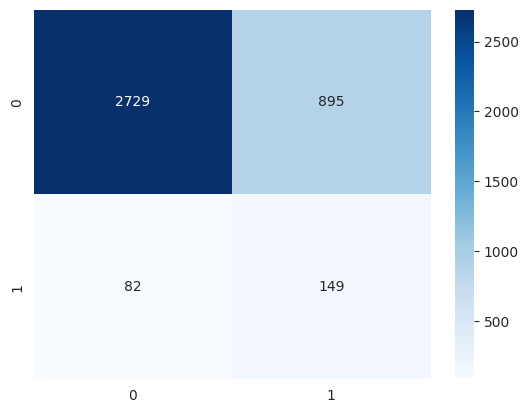

In [92]:
sns.heatmap(cf_matrix_f1, annot=True, fmt='.0f', cmap='Blues')

<Axes: >

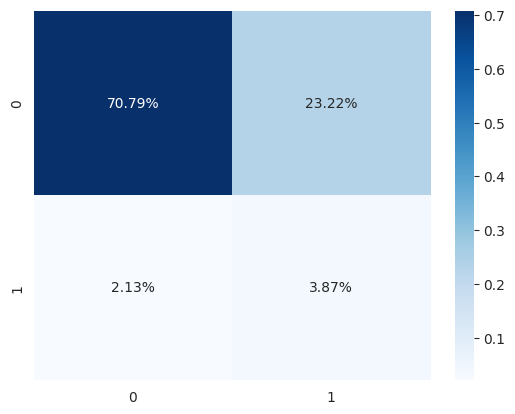

In [93]:
sns.heatmap(cf_matrix_f1/np.sum(cf_matrix_f1), annot=True, fmt = '.2%',
            cmap='Blues')

###Shap

In [97]:
explainer_f1 = shap.TreeExplainer(best_model_f1)
shap_values_f1 = explainer_f1.shap_values(X_test)

Feature significance chart


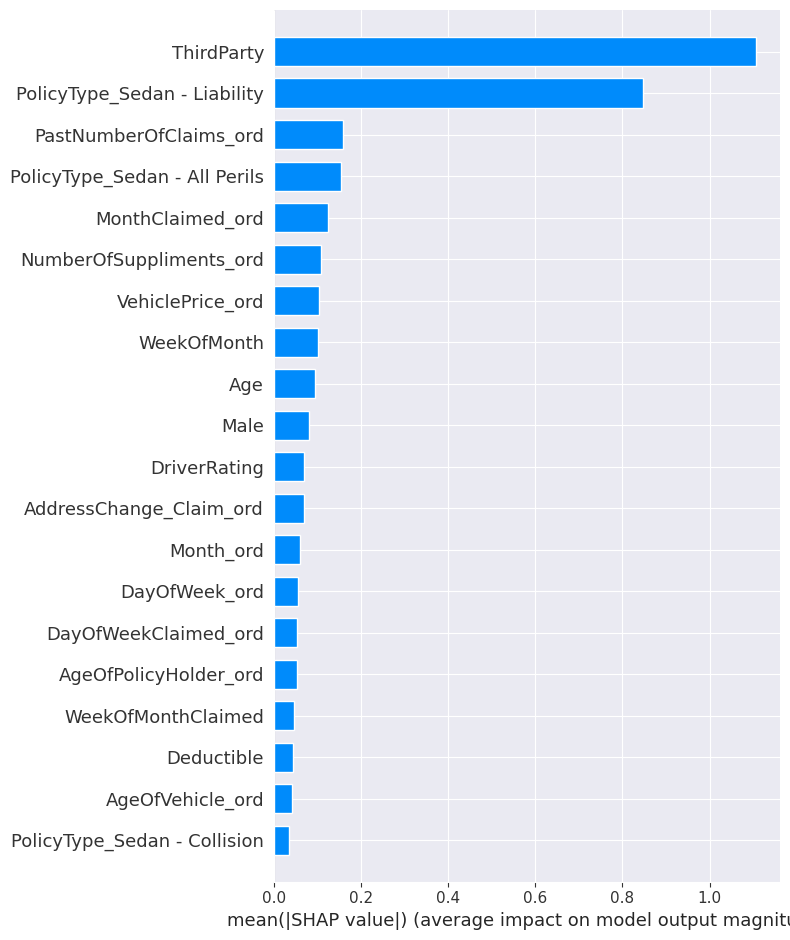

In [99]:
print('Feature significance chart')
shap.summary_plot(shap_values_f1, X_test, plot_type='bar')

The two strongest features are 'ThirdParty' and 'PolicyType_Sedan - Liability'. Both of these features are negatively correlated with frauds.
Whereas the feature 'PolicyType_Sedan - All Perills' is positively correlated, but the correlation is not strong.

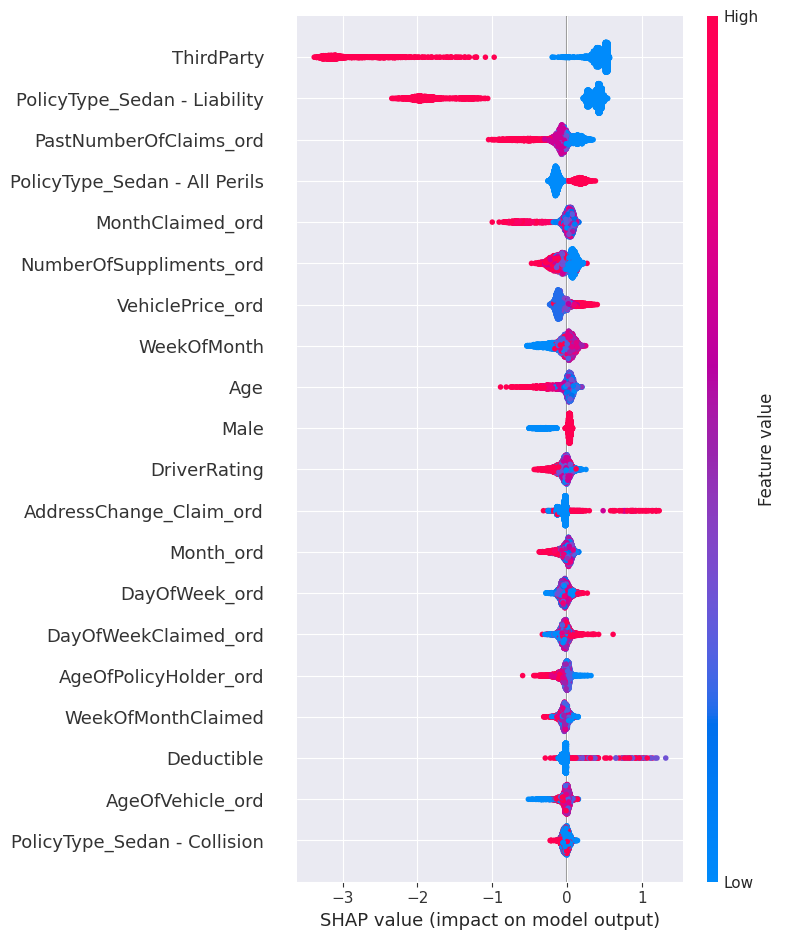

In [179]:
shap.summary_plot(shap_values_f1, X_test)

In [ ]:
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)

##Maximizing Recall
>In fraud detection, where the error cost of missing fraud is significant, the priority is to maximize the model's ability to detect actual fraud. Then the 'recall' metric may be better for assessing the effectiveness of the model. At the same time, it is good to monitor 'precision' to avoid too many false accusations.

###XGBoost

In [100]:
def objective_XGB_recall(trial):

  params = {'objective': 'binary:logistic',
            'eval_metric': 'logloss',
            'scale_pos_weight': imbalance_ratio,
            'n_estimators': trial.suggest_int('n_estimators', 100, 600),
            'max_depth': trial.suggest_int('max_depth', 3, 12),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
            'lambda': trial.suggest_float('lambda', 1, 10),
            'alpha': trial.suggest_float('alpha', 1, 10),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 1.0),
            'subsample': trial.suggest_float('subsample', 0.3, 1.0),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
            'random_state': 6}

  optuna_model = xgb.XGBClassifier(**params)
  cvs = cross_val_score(optuna_model, cv=skf, X=X_train, y=y_train, scoring='recall')
  score = cvs.mean()

  return score

In [140]:
sampler = optuna.samplers.TPESampler(seed=6)
study_XGB_recall = optuna.create_study(direction='maximize', sampler=sampler)

[I 2023-10-11 14:22:15,753] A new study created in memory with name: no-name-bef80ae1-f3b7-4ad9-895f-b1efe0d54547


In [ ]:
study_XGB_recall.optimize(objective_XGB_recall, n_trials=400, show_progress_bar=True)

In [142]:
params_XGB_recall = study_XGB_recall.best_params
params_XGB_recall

{'n_estimators': 100,
 'max_depth': 3,
 'learning_rate': 0.043903064744472094,
 'lambda': 9.150727325329848,
 'alpha': 3.4823511200794512,
 'colsample_bytree': 0.6770879670837924,
 'subsample': 0.8489782731004059,
 'min_child_weight': 2}

In [143]:
model_XGB_recall = xgb.XGBClassifier(**params_XGB_recall, random_state=6, objective='binary:logistic',
            eval_metric='logloss', scale_pos_weight=imbalance_ratio)
metrics_XGB_recall = get_result(model_XGB_recall, X_train, X_val, y_train, y_val)
metrics_XGB_recall

,F1,P-R,ROC-AUC,recall,precision,accuracy
TRAIN,0.2370,0.1310,0.7794,0.9401,0.1356,0.638
VAL,0.2367,0.1296,0.7729,0.9183,0.1358,0.645


In [144]:
optuna.visualization.plot_parallel_coordinate(study_XGB_recall)

In [145]:
optuna.visualization.plot_optimization_history(study_XGB_recall)

###LightGBM

In [108]:
def objective_LGBM_recall(trial):

  params = {'objective': 'binary',
            'metric': 'recall',
            'max_depth': trial.suggest_int('max_depth', 3, 15),
            'n_estimators' : trial.suggest_int('n_estimators', 20, 600),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
            'num_leaves': trial.suggest_int('num_leaves', 20, 300),
            'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.2, 1.0),
            'subsample': trial.suggest_float('subsample', 0.3, 1.0),
            'scale_pos_weight': imbalance_ratio,
            'random_state': 6,
            'verbose': -1}

  optuna_model = lgb.LGBMClassifier(**params)
  cvs = cross_val_score(optuna_model, cv=skf, X=X_train, y=y_train, scoring='recall')
  score = cvs.mean()

  return score

In [109]:
sampler = optuna.samplers.TPESampler(seed=6)
study_LGBM_recall = optuna.create_study(direction='maximize', sampler=sampler)

[I 2023-10-11 11:38:51,137] A new study created in memory with name: no-name-3514ad64-5094-4975-b29d-ca528ab3ba3d


In [ ]:
study_LGBM_recall.optimize(objective_LGBM_recall, n_trials=500, show_progress_bar=True)

In [111]:
params_LGBM_recall = study_LGBM_recall.best_params
params_LGBM_recall

{'max_depth': 3,
 'n_estimators': 37,
 'learning_rate': 0.07905945506087077,
 'num_leaves': 190,
 'min_child_samples': 83,
 'colsample_bytree': 0.849857057283525,
 'subsample': 0.8803111902312353}

In [112]:
model_LGBM_recall = lgb.LGBMClassifier(**params_LGBM_recall, objective='binary', metric='recall',
                                scale_pos_weight=imbalance_ratio, verbose=-1, random_state=6)
metrics_LGBM_recall = get_result(model_LGBM_recall, X_train, X_val, y_train, y_val)
metrics_LGBM_recall

,F1,P-R,ROC-AUC,recall,precision,accuracy
TRAIN,0.2376,0.1312,0.7790,0.9360,0.1361,0.6408
VAL,0.2329,0.1261,0.7627,0.8942,0.1339,0.6470


In [184]:
optuna.visualization.plot_parallel_coordinate(study_LGBM_recall)

In [114]:
optuna.visualization.plot_optimization_history(study_LGBM_recall)

###CatBoost

In [115]:
def objective_CB_recall(trial):

  params = {'n_estimators': trial.suggest_int('n_estimators', 100, 600),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
            'bagging_temperature': trial.suggest_float('bagging_temperature', 0.3, 1),
            'colsample_bylevel': trial.suggest_float('bagging_temperature', 0.3, 1),
            'border_count': trial.suggest_int('border_count', 32, 255),
            'loss_function': 'Logloss',
            'class_weights': [1, 17],
            'random_state': 6,
            'verbose': False}

  optuna_model = ctb.CatBoostClassifier(**params)
  cvs = cross_val_score(optuna_model, cv=skf, X=X_train, y=y_train, scoring='recall')
  score = cvs.mean()

  return score

In [116]:
sampler = optuna.samplers.TPESampler(seed=6)
study_CB_recall = optuna.create_study(direction='maximize', sampler=sampler)

[I 2023-10-11 11:51:26,759] A new study created in memory with name: no-name-285a244b-6674-42de-bd2a-6b003d3940c6


In [ ]:
study_CB_recall.optimize(objective_CB_recall, n_trials=400, show_progress_bar=True)

In [118]:
params_CB_recall = study_CB_recall.best_params
params_CB_recall

{'n_estimators': 144,
 'max_depth': 3,
 'learning_rate': 0.011132541504315897,
 'l2_leaf_reg': 9.809064362791359,
 'bagging_temperature': 0.5805605270074022,
 'border_count': 255}

In [119]:
model_CB_recall = ctb.CatBoostClassifier(**params_CB_recall, class_weights=[1, 17],
                                   random_seed=6, eval_metric='Recall', verbose=False)
metrics_CB_recall = get_result(model_CB_recall, X_train, X_val, y_train, y_val)
metrics_CB_recall

,F1,P-R,ROC-AUC,recall,precision,accuracy
TRAIN,0.2220,0.1227,0.7665,0.9566,0.1256,0.5991
VAL,0.2246,0.1239,0.7668,0.9471,0.1274,0.6081


In [120]:
model_CB_recall = ctb.CatBoostClassifier(**params_CB_recall, class_weights=[1, 17],
                                   random_seed=6, eval_metric='F1', verbose=False)
metrics_CB_recall = get_result(model_CB_recall, X_train, X_val, y_train, y_val)
metrics_CB_recall

,F1,P-R,ROC-AUC,recall,precision,accuracy
TRAIN,0.2220,0.1227,0.7665,0.9566,0.1256,0.5991
VAL,0.2246,0.1239,0.7668,0.9471,0.1274,0.6081


In [185]:
optuna.visualization.plot_parallel_coordinate(study_CB_recall)

In [122]:
optuna.visualization.plot_optimization_history(study_CB_recall)

###Results

In [146]:
result = pd.concat([metrics_XGB_recall, metrics_LGBM_recall, metrics_CB_recall], keys=['XGBoost', 'LightGBM', 'CatBoost'])
result

F1     P-R  ROC-AUC  recall  precision  accuracy
XGBoost  TRAIN  0.2370  0.1310   0.7794  0.9401     0.1356    0.6380
         VAL    0.2367  0.1296   0.7729  0.9183     0.1358    0.6450
LightGBM TRAIN  0.2376  0.1312   0.7790  0.9360     0.1361    0.6408
         VAL    0.2329  0.1261   0.7627  0.8942     0.1339    0.6470
CatBoost TRAIN  0.2220  0.1227   0.7665  0.9566     0.1256    0.5991
         VAL    0.2246  0.1239   0.7668  0.9471     0.1274    0.6081

In [147]:
best_model_recall = model_CB_recall

y_test_pred_recall = best_model_recall.predict(X_test)

In [148]:
calculate_metrics(y_test, y_test_pred_recall)

,F1,P-R,ROC-AUC,recall,precision,accuracy
0,0.2204,0.1221,0.7661,0.9654,0.1244,0.5907


In [149]:
cf_matrix_recall = confusion_matrix(y_test, y_test_pred_recall)
cf_matrix_recall

array([[2054, 1570],
       [   8,  223]])

<Axes: >

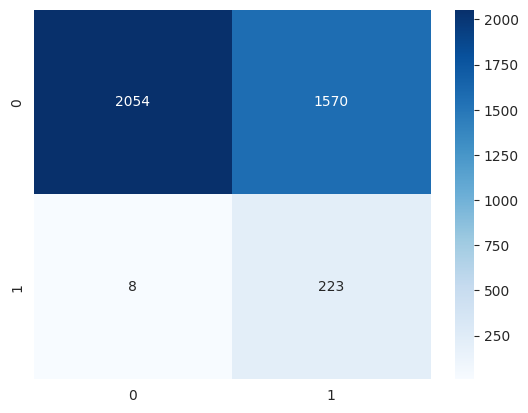

In [150]:
sns.heatmap(cf_matrix_recall, annot=True, fmt='.0f', cmap='Blues')

<Axes: >

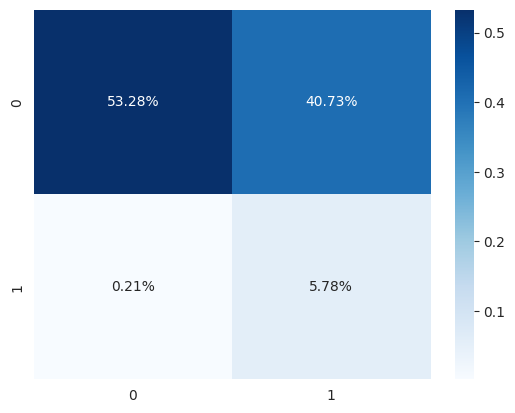

In [151]:
sns.heatmap(cf_matrix_recall/np.sum(cf_matrix_recall), annot=True, fmt = '.2%',
            cmap='Blues')

###Shap

In [152]:
explainer_recall = shap.TreeExplainer(best_model_recall)
shap_values_recall = explainer_recall.shap_values(X_test)

Feature significance chart


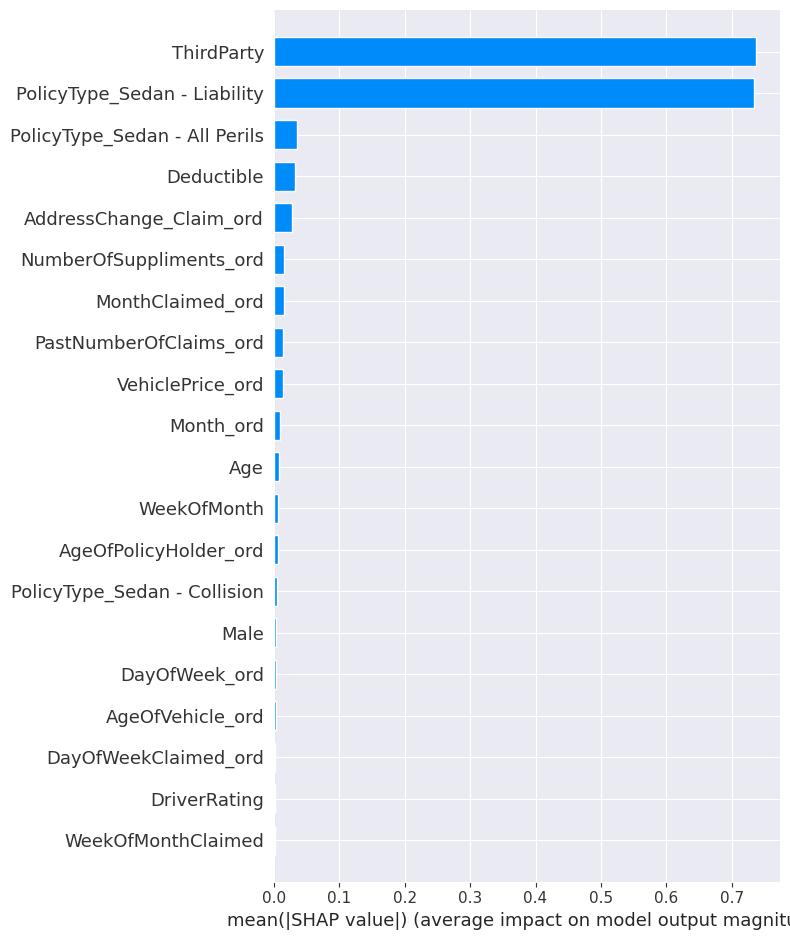

In [171]:
print('Feature significance chart')
shap.summary_plot(shap_values_recall, X_test, plot_type='bar')

Similarly to metric 'F1' the two strongest features are 'ThirdParty' and 'PolicyType_Sedan - Liability'. Both of these features are negatively correlated with frauds.

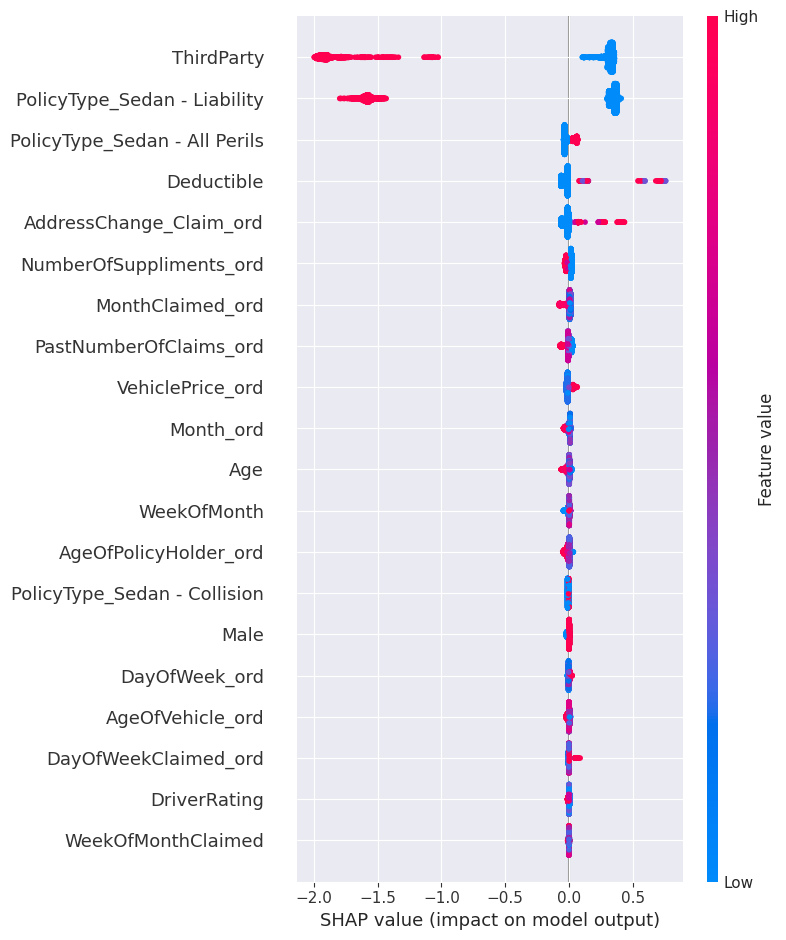

In [180]:
shap.summary_plot(shap_values_recall, X_test)